## DNN - By Hugo

IMPORT SIDE

In [210]:
import os
import torch
import torch.nn as nn
from torch.nn.modules.activation import Threshold
from sklearn.datasets import make_circles
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tqdm as notebook_tqdm

DEVICE SIDE

In [211]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DNN SIDE

In [212]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.archiNN = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.archiNN(x)
    
dnn = DNN(2, 32, 1).to(device)

DATASET SIDE

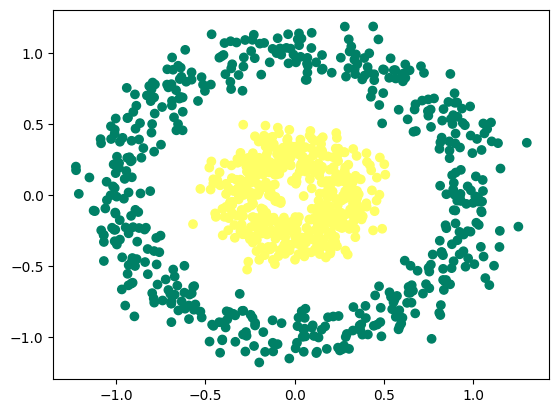

In [213]:
X_train, y_train = make_circles(n_samples=1000, noise=0.1, factor=0.3, random_state=0)
X_test, y_test = make_circles(n_samples=200, noise=0.1, factor=0.3, random_state=1)
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape((1, y_train.shape[0]))
y_test = y_test.reshape((1, y_test.shape[0]))

# SHOW MY DATASET
plt.scatter(X_train[0, :], X_train[1, :], c=y_train, cmap='summer')
plt.show()

In [214]:
batch_size = 8
train_inputs_tensor = torch.tensor(X_train.T, dtype=torch.float32).to(device)
train_outputs_tensor = torch.tensor(y_train.T, dtype=torch.float32).to(device)

test_inputs_tensor = torch.tensor(X_test.T, dtype=torch.float32).to(device)
test_outputs_tensor = torch.tensor(y_test.T, dtype=torch.float32).to(device)

trainset = TensorDataset(train_inputs_tensor, train_outputs_tensor)
testset = TensorDataset(test_inputs_tensor, test_outputs_tensor)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr=1e-3)

TRAINSIDE

In [215]:
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

In [216]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0
    total = 0
    nombre_vp = 0
    nombre_fp = 0
    nombre_fn = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = y_pred >= 0.5
        correct += (predictions == y).sum().item()
        total += y.size(0)

        nombre_vp += ((predictions == 1) & (y == 1)).sum().item()
        nombre_fp += ((predictions == 1) & (y == 0)).sum().item()
        nombre_fn += ((predictions == 0) & (y == 1)).sum().item()

    epoch_loss /= size
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy

In [217]:
def test(dataloader, model, loss_fn):
	model.eval()
	size = len(dataloader.dataset)
	epoch_loss = 0
	correct = 0
	total = 0
	nombre_vp = 0
	nombre_fp = 0
	nombre_fn = 0

	with torch.no_grad():
		for X, y in dataloader:
			X, y = X.to(device), y.to(device)

			y_pred = model(X)
			loss = loss_fn(y_pred, y)
			epoch_loss += loss.item()

			predictions = y_pred >= 0.5
			correct += (predictions == y).sum().item()
			total += y.size(0)

			nombre_vp += ((predictions == 1) & (y == 1)).sum().item()
			nombre_fp += ((predictions == 1) & (y == 0)).sum().item()
			nombre_fn += ((predictions == 0) & (y == 1)).sum().item()

	epoch_loss /= size
	epoch_accuracy = correct / total

	return epoch_loss, epoch_accuracy

In [218]:
num_epoch = 10

for epoch in notebook_tqdm.tqdm(range(num_epoch)):
	train_loss, train_accuracy = train(trainloader, dnn, loss_fn, optimizer)
	train_losses.append(train_loss)
	train_accuracies.append(train_accuracy)

	test_loss, test_accuracy = test(testloader, dnn, loss_fn)
	test_losses.append(test_loss)
	test_accuracies.append(test_accuracy)

100%|██████████| 10/10 [00:01<00:00,  9.72it/s]


<Figure size 640x480 with 0 Axes>

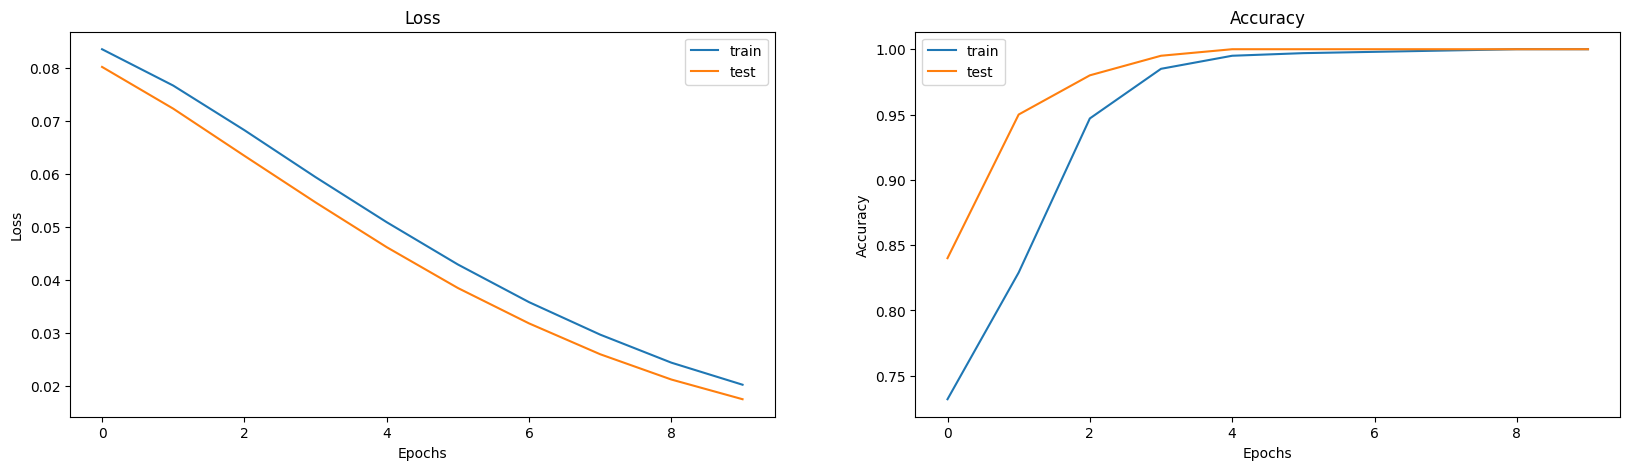

In [219]:
plt.clf()

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(test_accuracies, label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.show()

In [220]:
test_inputs, test_labels = make_circles(n_samples=10, noise=0.1, factor=0.3, random_state=1)

test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).to(device)

print(test_labels_tensor)

with torch.no_grad():
    predictions = dnn(test_inputs_tensor)

binary_predictions = (predictions.cpu().detach().numpy() > 0.5).astype(int)

print("Binary predictions:", binary_predictions.T)

tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 1.])
Binary predictions: [[0 1 1 0 0 0 0 1 1 1]]
